In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
from googletrans import Translator
from datetime import datetime

sns.set_style("darkgrid")
sns.set_palette("hls", 8)

In [2]:
hotel_info_path = '../web-scraping/d1fe8412-b9cb-46b9-ab5b-b5116e3fa965_The Social Hub Groningen_17-12-2023_19-11.json'

with open(hotel_info_path, 'r') as f:
    hotel_info_data = json.load(f)

hotel_info_data

{'hotel_name': 'The Social Hub Groningen',
 'hotel_link': 'https://www.booking.com/hotel/nl/the-social-hub-groningen.en.html',
 'address': 'Boterdiep 9, 9712 LH Groningen, Netherlands',
 'scraping_date': '17-12-2023_19-11',
 'nr_reviews': 3298,
 'overall_score': 8.3}

# Dataset
    - review_title (string) = the title of the review
    - review_date (string) = the date when the review was posted
    - reviewer_country (string) - the country of the reviewer
    - room_type (string) = the type of room as defined by each hotel (example: Deluxe King Room)
    - party_size (string) = the type of group traveling (example: couple, family)
    - nr_nights (int) = the number of nights stayed in the hotel
    - date_stay (string) = the starting date of the stay in the hotel
    - review_score (float) = the score given by the reviewer
    - review_great (string) = the text of the positive review. If missing, then N/A.
    - review_poor (string) = The text of the negative review. If missing, then N/A.
    - hotel_response_bool (bool) = Whether or not the hotel has responded to the review.

In [7]:
hotel_reviews_path = '../web-scraping/d1fe8412-b9cb-46b9-ab5b-b5116e3fa965_The Social Hub Groningen_17-12-2023_19-11.csv'

hotel_reviews_data = pd.read_csv(hotel_reviews_path)
hotel_reviews_data.head()

,review_title,review_date,reviewer_country,room_type,party_size,nr_nights,date_stay,review_score,review_great,review_poor,hotel_response_bool
0,Exceptional,08-2022,Turkey,Deluxe King Room,Solo traveller,1,08-2022,10.0,Everything was perfect. + shower gel and soap ...,NaN,False
1,"Great place, great staff, great breakfast",12-2023,United States,Deluxe King Room,Solo traveller,3,12-2023,8.0,"Good vibe, young, modern, easy",NaN,True
2,Good place to stay.,11-2023,United States,Deluxe King Room,Couple,3,11-2023,8.0,The hotel was nice and had good amenities. Sta...,The arrangements for the laundry were challeng...,True
3,Good,08-2023,Germany,Standard Queen Room,Couple,6,08-2023,7.0,Very friendly staff and good location.,Very simple and not completely cleaned room.,True
4,I would come back :),10-2023,Germany,Standard Queen Room,Solo traveller,1,10-2023,8.0,"The location is great, good atmosphere with ma...","Staff was friendly, but not always where I exp...",True


# Pre-processing
- Some reviews were scraped multiple times so remove those
- translate all reviews to English, it looks like the translation did not work for all reviews during web scraping.
- Some people write things like "nothing" in the poor review so we don't want those reviews to count as negative. Those reviews will be replaced with N/A. 

In [8]:
def is_english(text):
    try:
        lang = detect(text)
        return lang == 'en'
    except:
        return False

def translate_to_english(text):
    try:
        if not is_english(text):
            translator = Translator()
            translation = translator.translate(text, dest='en')
            return translation.text
    except:
        pass
    return text

hotel_reviews_data = hotel_reviews_data.drop_duplicates()

# hotel_reviews_data['review_title'] = hotel_reviews_data['review_title'].apply(translate_to_english)
# hotel_reviews_data['review_poor'] = hotel_reviews_data['review_poor'].apply(translate_to_english)
# hotel_reviews_data['review_great'] = hotel_reviews_data['review_great'].apply(translate_to_english)

hotel_reviews_data_english = hotel_reviews_data[hotel_reviews_data['review_poor'].apply(is_english) & hotel_reviews_data['review_great'].apply(is_english)]
hotel_reviews_data.loc[hotel_reviews_data['review_poor'].str.contains('nothing|nil|niks|Niets|-', case=False, na=False), 'review_poor'] = pd.NA

hotel_reviews_data

,review_title,review_date,reviewer_country,room_type,party_size,nr_nights,date_stay,review_score,review_great,review_poor,hotel_response_bool
0,Exceptional,08-2022,Turkey,Deluxe King Room,Solo traveller,1,08-2022,10.0,Everything was perfect. + shower gel and soap ...,NaN,False
1,"Great place, great staff, great breakfast",12-2023,United States,Deluxe King Room,Solo traveller,3,12-2023,8.0,"Good vibe, young, modern, easy",NaN,True
2,Good place to stay.,11-2023,United States,Deluxe King Room,Couple,3,11-2023,8.0,The hotel was nice and had good amenities. Sta...,The arrangements for the laundry were challeng...,True
3,Good,08-2023,Germany,Standard Queen Room,Couple,6,08-2023,7.0,Very friendly staff and good location.,Very simple and not completely cleaned room.,True
4,I would come back :),10-2023,Germany,Standard Queen Room,Solo traveller,1,10-2023,8.0,"The location is great, good atmosphere with ma...","Staff was friendly, but not always where I exp...",True
...,...,...,...,...,...,...,...,...,...,...,...
3305,Exceptional,03-2022,Netherlands,NaN,Couple,2,03-2022,10.0,NaN,NaN,False
3306,Exceptional,08-2021,Romania,NaN,Family,3,08-2021,10.0,NaN,NaN,False
3307,Okay,08-2021,Germany,NaN,Solo traveller,2,08-2021,5.8,NaN,NaN,False
3308,Exceptional,06-2021,Slovenia,NaN,Family,3,06-2021,10.0,NaN,NaN,False


# Save the preprocessed dataset

In [ ]:
# hotel_reviews_data.to_csv('preprocessed_booking_reviews.csv', index=False)

In [9]:
num_entries = hotel_reviews_data.shape[0]
print("Total number of entries:", num_entries)

num_entries_review_poor_notna = hotel_reviews_data['review_poor'].notna().sum()
print("Number of negative reviews:", num_entries_review_poor_notna)

num_entries_review_poor_notna = hotel_reviews_data['review_great'].notna().sum()
print("Number of positive reviews:", num_entries_review_poor_notna)

num_entries_review_poor_or_great_notna = hotel_reviews_data[['review_poor', 'review_great']].notna().any(axis=1).sum()
print("Number of entries with at least one type of review:", num_entries_review_poor_or_great_notna)

mean_review_score = hotel_reviews_data['review_score'].mean()
print("Mean review_score for all entries:", mean_review_score)


Total number of entries: 2999
Number of negative reviews: 936
Number of positive reviews: 1460
Number of entries with at least one type of review: 1505
Mean review_score for all entries: 8.328342780926976


# Review score over time

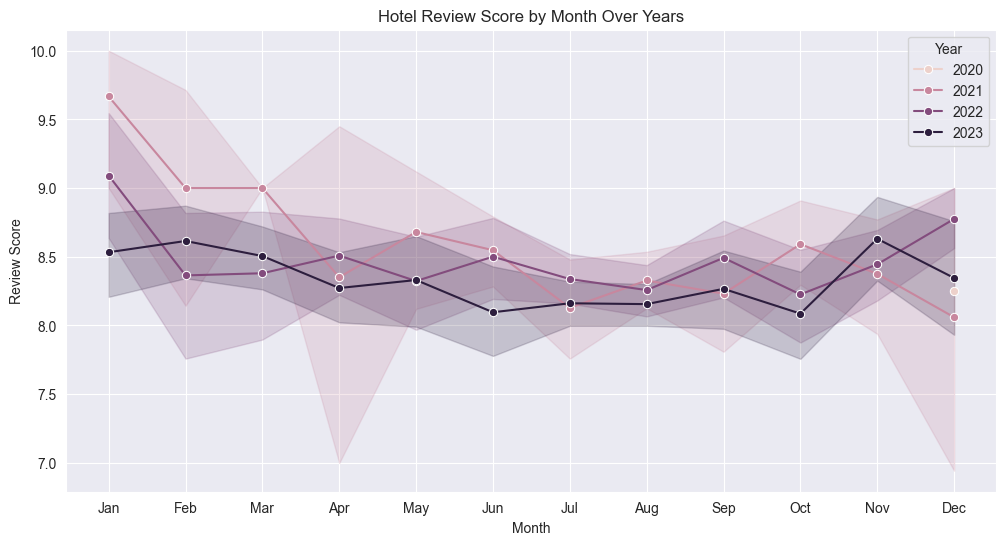

In [10]:
hotel_reviews_data['review_date'] = pd.to_datetime(hotel_reviews_data['review_date'], format='%m-%Y')

# Extract month, year, and season
hotel_reviews_data['month'] = hotel_reviews_data['review_date'].dt.month
hotel_reviews_data['year'] = hotel_reviews_data['review_date'].dt.year
hotel_reviews_data['season'] = hotel_reviews_data['review_date'].dt.month % 12 // 3 + 1

# Map season numbers to season names
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
hotel_reviews_data['season'] = hotel_reviews_data['season'].map(seasons)

plt.figure(figsize=(12, 6))
sns.lineplot(data=hotel_reviews_data, x='month', y='review_score', hue='year', marker='o')
plt.title('Hotel Review Score by Month Over Years')
plt.xlabel('Month')
plt.ylabel('Review Score')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

# Sentiment (number of review_poor and review_great) over time

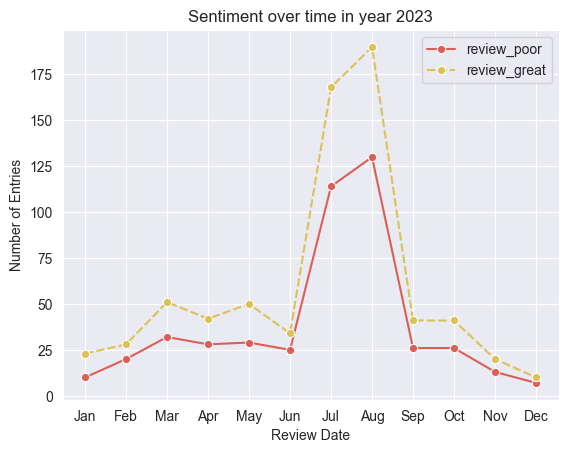

In [11]:
# Specify the year you want to analyze
selected_year = 2023 

# Filter the data for the selected year
filtered_data = hotel_reviews_data[hotel_reviews_data['review_date'].dt.year == selected_year]
# Group by month and count the number of entries in review_poor and review_great
entries_over_time = filtered_data.groupby(filtered_data['review_date'].dt.month)[['review_poor', 'review_great']].count()

sns.lineplot(data=entries_over_time, marker='o')
plt.title(f'Sentiment over time in year {selected_year}')
plt.xlabel('Review Date')
plt.ylabel('Number of Entries')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


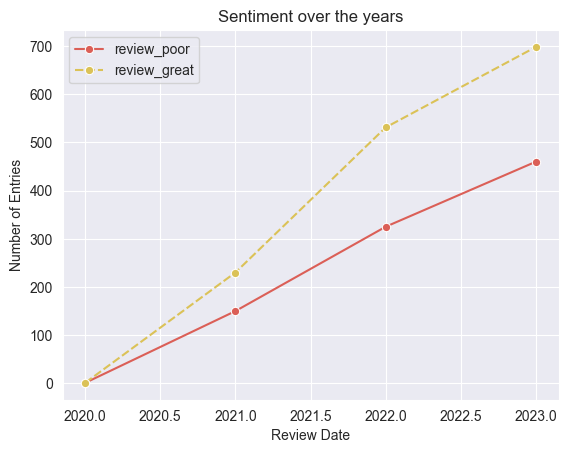

In [12]:
entries_over_time = hotel_reviews_data.groupby('year')[['review_poor', 'review_great']].count()

sns.lineplot(data=entries_over_time, marker='o')
plt.title(f'Sentiment over the years')
plt.xlabel('Review Date')
plt.ylabel('Number of Entries')
# plt.xticks(range(1, 5), ['2020', '2021', '2022', '2023'])
plt.grid(True)
plt.show()

# Review score per country

                  Counts  Mean Review Score
reviewer_country                           
India                  4           8.500000
Netherlands         1313           8.236177
Romania               59           9.084746
United Kingdom        48           8.541667


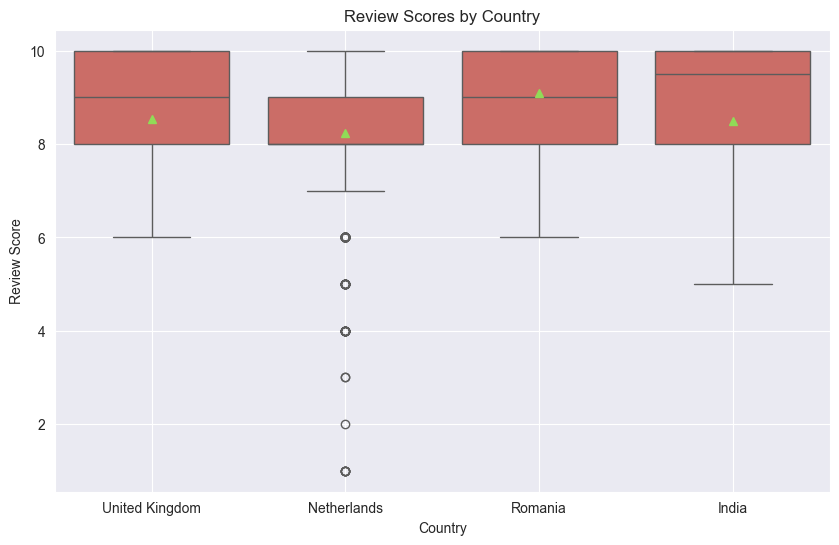

In [13]:
selected_countries = ['Netherlands', 'Romania', 'United Kingdom', 'India']  # Replace with the countries you want to show
filtered_data = hotel_reviews_data[hotel_reviews_data['reviewer_country'].isin(selected_countries)]

country_counts = filtered_data['reviewer_country'].value_counts()
country_mean_score = filtered_data.groupby('reviewer_country')['review_score'].mean()

country_table = pd.DataFrame({'Counts': country_counts, 'Mean Review Score': country_mean_score})
print(country_table)

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='reviewer_country', y='review_score', showmeans=True)
plt.title('Review Scores by Country')
plt.xlabel('Country')
plt.ylabel('Review Score')
plt.grid(True)
plt.show()

# Review score per room type

                     Counts  Mean Review Score
room_type                                     
Deluxe King Room       1111           8.488749
Deluxe Queen Room         2           8.000000
Deluxe Studio            76           7.302632
Standard Queen Room    1719           8.275393


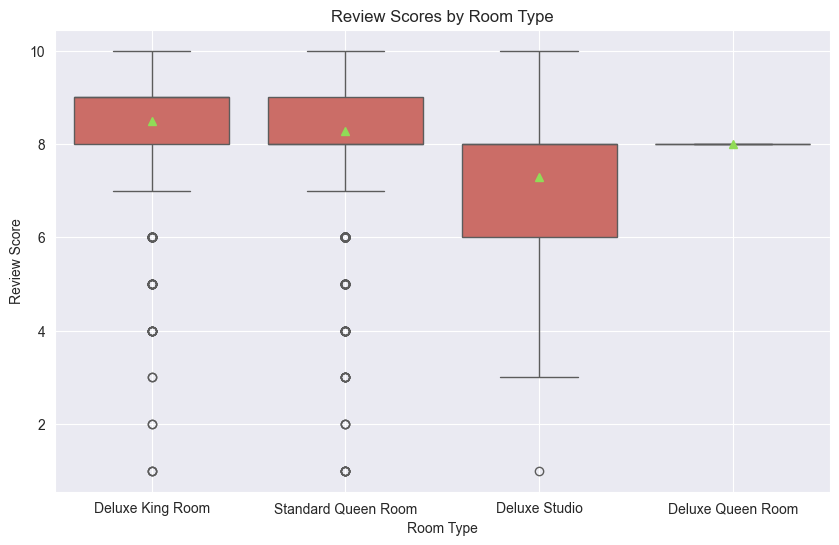

In [14]:
room_type_counts = hotel_reviews_data['room_type'].value_counts()
room_type_mean_score = hotel_reviews_data.groupby('room_type')['review_score'].mean()

room_type_table = pd.DataFrame({'Counts': room_type_counts, 'Mean Review Score': room_type_mean_score})
print(room_type_table)

plt.figure(figsize=(10, 6))
sns.boxplot(data=hotel_reviews_data, x='room_type', y='review_score', showmeans=True)
plt.title('Review Scores by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Review Score')
plt.grid(True)
plt.show()


# Keyword extraction with Rake

In [11]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from rake_nltk import Rake
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords

In [12]:
def extract_keywords(text):
    if pd.isna(text) or text == 'N/A':
        return []
    
    rake = Rake(max_length=3, include_repeated_phrases=False, word_tokenizer=word_tokenize)
    rake.extract_keywords_from_text(text)
    rake_phrases = rake.get_ranked_phrases()[:3]

    # Tokenize and POS tag each phrase
    tagged_phrases = [pos_tag(word_tokenize(phrase)) for phrase in rake_phrases]

    # Filter out phrases with verbs
    filtered_phrases = [
        ' '.join(word for word, tag in phrase if 'VB' not in tag) for phrase in tagged_phrases
    ]

    return filtered_phrases


hotel_reviews_data['review_great_keywords'] = hotel_reviews_data['review_great'].apply(extract_keywords)
hotel_reviews_data['review_poor_keywords'] = hotel_reviews_data['review_poor'].apply(extract_keywords)

hotel_reviews_data.head()

# hotel_reviews_data['review_great_keywords'].head()
# hotel_reviews_data['review_poor_keywords'].head()

,review_title,review_date,reviewer_country,room_type,party_size,nr_nights,date_stay,review_score,review_great,review_poor,hotel_response_bool,month,year,season,review_great_keywords,review_poor_keywords
0,Exceptional,2022-08-01,Turkey,Deluxe King Room,Solo traveller,1,08-2022,10.0,Everything was perfect. + shower gel and soap ...,NaN,False,8,2022,Summer,"[soap amazing, shower gel, thank]",[]
1,"Great place, great staff, great breakfast",2023-12-01,United States,Deluxe King Room,Solo traveller,3,12-2023,8.0,"Good vibe, young, modern, easy",NaN,True,12,2023,Winter,"[good vibe, young, modern]",[]
2,Good place to stay.,2023-11-01,United States,Deluxe King Room,Couple,3,11-2023,8.0,The hotel was nice and had good amenities. Sta...,The arrangements for the laundry were challeng...,True,11,2023,Fall,"[good amenities, staff, nice]","[booking.com, 1 per room, outside food]"
3,Good,2023-08-01,Germany,Standard Queen Room,Couple,6,08-2023,7.0,Very friendly staff and good location.,Very simple and not completely cleaned room.,True,8,2023,Summer,"[good location, friendly staff]","[completely cleaned room, simple]"
4,I would come back :),2023-10-01,Germany,Standard Queen Room,Solo traveller,1,10-2023,8.0,"The location is great, good atmosphere with ma...","Staff was friendly, but not always where I exp...",True,10,2023,Fall,"[different restaurants nearby, 400, quite big]","[till someone, someone, right next]"


# Sentiment anlysis

I will apply the model to each review (great and poor) and get the sentiments + score. The reviews are already labeled on booking, but most websites have only one review.

In [37]:
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    top_k=None
)

def classify_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return None
    return distilled_student_sentiment_classifier(text)

# Apply sentiment analysis to the 'review_poor' and 'review_great' columns
hotel_reviews_data['review_poor_sentiment'] = hotel_reviews_data['review_poor'].apply(classify_sentiment)
hotel_reviews_data['review_great_sentiment'] = hotel_reviews_data['review_great'].apply(classify_sentiment)


In [43]:
display(hotel_reviews_data['review_great'].head()[0])
display(hotel_reviews_data['review_great_sentiment'].head()[0])

display(hotel_reviews_data['review_poor'].head()[3])
display(hotel_reviews_data['review_poor_sentiment'].head()[3])

'Everything was perfect. + shower gel and soap smelled amazing! :) Thank you.'

[[{'label': 'positive', 'score': 0.9723107218742371},
  {'label': 'neutral', 'score': 0.019118472933769226},
  {'label': 'negative', 'score': 0.008570682257413864}]]

'Very simple and not completely cleaned room.'

[[{'label': 'neutral', 'score': 0.4742788076400757},
  {'label': 'positive', 'score': 0.4404342472553253},
  {'label': 'negative', 'score': 0.08528698980808258}]]

# Sentiment analysis with Mistral

In [15]:
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

e:\RUG\Pie\reviews_analytics\review-analytics-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup model

In [16]:
# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GGUF",
    model_file="mistral-7b-instruct-v0.1.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=0,
    hf=True
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

# Pipeline
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50,
    repetition_penalty=1.1
)

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


# Prompt engeneering

In [17]:
example_prompt = """
<s>[INST]
I have the following hotel review:
Everything was perfect. + shower gel and soap smelled amazing! :) Thank you.

Extract only 1 sentiment from the possible labels: positive, negative, neutral. Say only the sentiment and nothing else.
[/INST] positive </s>
"""

sentiment_prompt = """
[INST]

I have the following document:
Very little: noise from the (busy) road can be heard in the room. It's as if the window doesn't close properly. I checked but saw no deviation (kmr 221).

Extract only 1 sentiment from the possible labels: positive, negative, neutral. Say only the sentiment and nothing else.
[/INST]
"""

prompt = example_prompt + sentiment_prompt

response = generator(prompt)
print(response[0]["generated_text"])


<s>[INST]
I have the following hotel review:
Everything was perfect. + shower gel and soap smelled amazing! :) Thank you.

Extract only 1 sentiment from the possible labels: positive, negative, neutral. Say only the sentiment and nothing else.
[/INST] positive </s>

[INST]

I have the following document:
Very little: noise from the (busy) road can be heard in the room. It's as if the window doesn't close properly. I checked but saw no deviation (kmr 221).

Extract only 1 sentiment from the possible labels: positive, negative, neutral. Say only the sentiment and nothing else.
[/INST]
negative


# Apply this to data, still needs to run

In [ ]:
def get_sentiment(review):
    # Format the prompt with the review
    example_prompt = f"""
    <s>[INST]
    I have the following hotel review:
    Everything was perfect. + shower gel and soap smelled amazing! :) Thank you.

    Extract only 1 sentiment from the possible labels: positive, negative, neutral. Say only the sentiment and nothing else.
    [/INST] positive </s>
    """

    sentiment_prompt = f"""
    [INST]

    I have the following hotel review:
    {review}

    Extract only 1 sentiment from the possible labels: positive, negative, neutral. Say only the sentiment and nothing else.
    [/INST]
    """

    prompt = example_prompt + sentiment_prompt
    # Generate the sentiment
    output = generator(prompt, max_length=512)
    sentiment = output[0]["generated_text"].linestrip()[-1]

    return sentiment


hotel_reviews_data_english['sentiment_poor'] = hotel_reviews_data_english['review_poor'].apply(get_sentiment)
hotel_reviews_data_english['sentiment_great'] = hotel_reviews_data_english['review_great'].apply(get_sentiment)

In [ ]:
hotel_reviews_data_english.head()